In [587]:
# Import dependencies
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env  # Change this import
from gymnasium.spaces import Box, Discrete  # Change this import
from gymnasium.utils import env_checker  # Import the environment checker

In [820]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,80), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        self.previous_lives = 2
        self.current_lives = self.previous_lives
        self.previous_score = 0
        
        self.pellet_address = 0x7268
        self.file_path = "pellet_count.txt"
        self.previous_pellet_count = self.read_pellet_count_from_file()
        
        self.cap = mss()
        self.game_location = {'top':50, 'left':-2280, 'width':2000, 'height':1300}
        self.score_location = {'top':380, 'left':-920, 'width':600, 'height':80} 
        self.done_location = {'top':520, 'left':-1800, 'width':450, 'height':70} 
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200}
        #self.done_location = {'top':508, 'left':-1810, 'width':450, 'height':80}     
        
    def read_pellet_count_from_file(self):
        try:
            with open(self.file_path, "r") as file:
                return int(file.read().strip())
        except (FileNotFoundError, ValueError):
            return 0
                 
    # Action that is called to do something in the game
    def step(self, action):
        # Action key - 0 = Move Left, 1 = Move Right, 2 = Move Up, 3 = Move Down, 4 = No op
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        
        if action != 4:
            pydirectinput.press(action_map[action])
            
        current_pellet_count = self.read_pellet_count_from_file()
        pellet_reward = self.get_pellet_reward(current_pellet_count)
        
        current_lives = self.get_lives()
        life_penalty = 0
        # Penalize only when a life is lost (and only once per life loss)
        if current_lives < self.previous_lives:
            life_penalty -= 500
            self.previous_lives = current_lives # update previous lives 
            
        reward = pellet_reward + life_penalty
        
        # Penalize heavily if all lives are lost
        done = self.get_done()
        # end_game_penalty = 0
        # if done:
        #     end_game_penalty -= 500
        # else: 
        #     end_game_penalty -= 0
            
    
        # Get the next observation
        new_observation = self.get_observation()
        
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, reward, done, False, info

    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        self.previous_pellet_count = self.read_pellet_count_from_file()
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel
    
    # Reward for eating pellets
    def get_pellet_reward(self, current_pellet_count):
        if current_pellet_count < self.previous_pellet_count:
            reward = 30 
            self.previous_pellet_count = current_pellet_count
        else:
            reward = 0    
        return reward
    
    def get_score(self):
        score_cap = np.array(self.cap.grab(self.score_location))[:,:,:3]
        score_gray =cv2.cvtColor(score_cap, cv2.COLOR_BGR2GRAY)
        _, score_thresh = cv2.threshold(score_gray, 150, 255, cv2.THRESH_BINARY)

        # Apply OCR on the processed image
        score_text = pytesseract.image_to_string(score_thresh, config='digits')
        
        try:
            score_value = int(score_text.strip())
        except ValueError:
            score_value = self.previous_score
            
        return score_cap, score_text
    
    def get_lives(self):   
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        
        # Load pacman life icon template
        pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        
        # Perform template matching
        result = cv2.matchTemplate(lives_gray, pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives
    
    def get_done(self):
        # Get the number of lives left 
        num_lives = self.get_lives()
        return num_lives == 0

In [821]:
env = PacMan()

In [787]:
current_pellet_count, obs, reward, done, truncated, info = env.step(env.action_space.sample())
print(current_pellet_count)
print(reward)

8650752
0


In [674]:
pellet_count = env.read_pellet_count_from_file()
pellet_count

5963776

In [710]:
current_pellet_count

11927552

In [547]:
channel = env.get_observation()

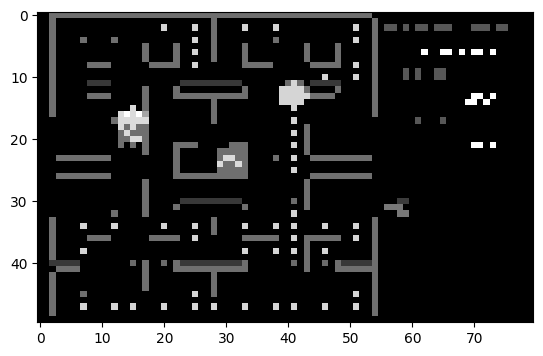

In [576]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

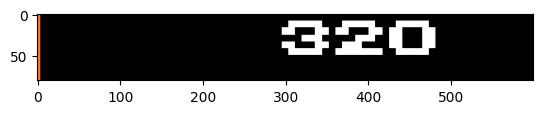

In [543]:
env = PacMan()
score_cap, score_text = env.get_score()
plt.imshow(score_cap)

In [544]:
score_text

'oer\n'

In [471]:
env.reset()

array([[[  0,   0, 111, ...,   0,   0,   0],
        [  0,   0, 111, ...,   0,   0,   0],
        [  0,   0, 111, ...,   0,   0,   0],
        ...,
        [  0,   0, 111, ...,   0,   0,   0],
        [  0,   0, 111, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

In [592]:
lives_cap, num_lives = env.get_lives()
num_lives

TypeError: cannot unpack non-iterable int object

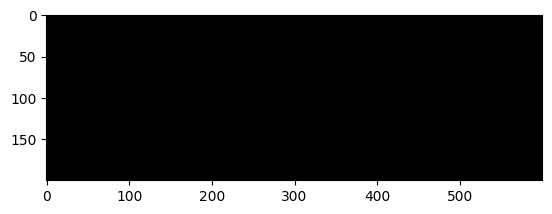

In [591]:
plt.imshow(lives_cap)

In [590]:
done = env.get_done()
done


False

In [441]:
env.render()

In [448]:
env.close()

In [473]:
# Game loop
obs = env.reset()
done = False

while not done:
    #env.render()  # Render the game screen
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, truncated, info = env.step(action)  # Take the step
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Graceful exit if 'q' is pressed
        done = True

KeyboardInterrupt: 

In [799]:
# Play 10 games
for episode in range(2):
    obs = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

Total Reward for episode 0 is -100
Total Reward for episode 1 is -40


In [822]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [824]:
env_checker.check_env(env)

In [823]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [825]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs'

In [826]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [827]:
from stable_baselines3 import DQN

In [828]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000, exploration_initial_eps=1.0, exploration_final_eps=0.1, exploration_fraction=0.1, learning_rate = 0.01 )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [829]:
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs\DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 130      |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 42       |
|    total_timesteps  | 99       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.6     |
|    ep_rew_mean      | 166      |
|    exploration_rate | 0.689    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 74       |
|    total_timesteps  | 173      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.8     |
|    ep_rew_mean      | 183      |
|    exploration_rate | 0.528    |
| time/               |        

In [830]:
model.load(os.path.join('train', 'best_model_5000'))


In [831]:
for episode in range(10):
    obs, _ = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 240
Total Reward for episode 1 is 180
Total Reward for episode 2 is 360
Total Reward for episode 3 is 150
Total Reward for episode 4 is 180
Total Reward for episode 5 is 0
Total Reward for episode 6 is 300
Total Reward for episode 7 is 240
Total Reward for episode 8 is 150
Total Reward for episode 9 is 180
